# Task 1 - User Overview Analysis 


In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np

 Extract and Load the xDR Dataset

In [2]:
import os
import sys
# Add the 'scripts' directory to the Python path for module imports
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

### Load the data from postgresql

In [3]:
# import load_data from scripts module
from db_connect import load_data

xdr_df = load_data()

Connection to database successful!


In [4]:
# Explre the first five rows
xdr_df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [5]:
# Let's check the size of the data
xdr_df.shape

(150001, 55)

In [6]:
object_columns = xdr_df.select_dtypes(include='object').columns
print(object_columns)

Index(['Start', 'End', 'Last Location Name', 'Handset Manufacturer',
       'Handset Type'],
      dtype='object')


In [7]:
# check missing data
missing_values = xdr_df.isnull().sum()

# Print columns with missing values only
missing_columns = missing_values[missing_values > 0]
print(missing_columns.reset_index())

                                       index       0
0                                  Bearer Id     991
1                                      Start       1
2                                   Start ms       1
3                                        End       1
4                                     End ms       1
5                                  Dur. (ms)       1
6                                       IMSI     570
7                              MSISDN/Number    1066
8                                       IMEI     572
9                         Last Location Name    1153
10                           Avg RTT DL (ms)   27829
11                           Avg RTT UL (ms)   27812
12                   Avg Bearer TP DL (kbps)       1
13                   Avg Bearer TP UL (kbps)       1
14               TCP DL Retrans. Vol (Bytes)   88146
15               TCP UL Retrans. Vol (Bytes)   96649
16                       DL TP < 50 Kbps (%)     754
17            50 Kbps < DL TP < 250 Kbps (%)  

**Approach to Handle Missing Values:**

Handling Missing Values in Key Columns

`Bearer Id, IMSI, MSISDN/Number, and IMEI`: These are key identifiers, and missing values here can mean lost user data. I may need to drop rows where these columns are missing, as they are essential for user-level aggregation.

`Avg RTT DL/UL (ms)`: These are performance metrics. If missing values are frequent, I might replace them with the mean/median of their respective columns.

Throughput Metrics `(DL TP and UL TP columns)`: Similarly, these columns can be filled with the mean or median values.

In [8]:
# Drop rows with missing IMSI, MSISDN/Number, IMEI, and Last Location Name (as they are key identifiers)
df_cleaned = xdr_df.dropna(subset=['Bearer Id', 'IMSI', 'MSISDN/Number', 'IMEI', 'Last Location Name'])

# List of throughput-related columns that may contain NaN values
throughput_columns = ['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
                      'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)', '250 Kbps < DL TP < 1 Mbps (%)', 
                      'DL TP > 1 Mbps (%)', 'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)', 
                      '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)']

# Filling NaN values with the mean for each column
df_cleaned.loc[:, throughput_columns] = df_cleaned[throughput_columns].fillna(df_cleaned[throughput_columns].mean())


In [9]:
# Fill NaN values in 'Total UL (Bytes)' and 'Total DL (Bytes)' with 0
df_cleaned.loc[:, ['Total UL (Bytes)', 'Total DL (Bytes)']] = df_cleaned[['Total UL (Bytes)', 'Total DL (Bytes)']].fillna(0)


In [10]:
# Check and drop duplicates
duplicate_count = df_cleaned.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_count}')

Number of duplicate rows: 0


In [11]:
df_cleaned.dtypes

Bearer Id                                   float64
Start                                        object
Start ms                                    float64
End                                          object
End ms                                      float64
Dur. (ms)                                   float64
IMSI                                        float64
MSISDN/Number                               float64
IMEI                                        float64
Last Location Name                           object
Avg RTT DL (ms)                             float64
Avg RTT UL (ms)                             float64
Avg Bearer TP DL (kbps)                     float64
Avg Bearer TP UL (kbps)                     float64
TCP DL Retrans. Vol (Bytes)                 float64
TCP UL Retrans. Vol (Bytes)                 float64
DL TP < 50 Kbps (%)                         float64
50 Kbps < DL TP < 250 Kbps (%)              float64
250 Kbps < DL TP < 1 Mbps (%)               float64
DL TP > 1 Mb

Handle outliers if any


In [12]:
import numpy as np

# Ensure were are working on a copy of the DataFrame to avoid setting issues
df_cleaned = df_cleaned.copy()

# Select only numeric columns (exclude location and date)
numeric_columns = df_cleaned.select_dtypes(include=[np.number]).columns

# Clip outliers for the numeric columns
for column in numeric_columns:
    lower_bound = df_cleaned[column].quantile(0.05)
    upper_bound = df_cleaned[column].quantile(0.95)
    df_cleaned.loc[:, column] = df_cleaned[column].clip(lower=lower_bound, upper=upper_bound)


In [13]:
# Convert 'Start' column to datetime format
import pandas as pd
df_cleaned['Start'] = pd.to_datetime(df_cleaned['Start'], format='%m/%d/%Y %H:%M')


In [14]:
# Check data type of 'Start' column
print(df_cleaned['Start'].dtype)

datetime64[ns]


Start by identifying the top 10 handsets used by the customers.

Then, identify the top 3 handset manufacturers

Next, identify the top 5 handsets per top 3 handset manufacturer

Make a short interpretation and recommendation to marketing teams


In [20]:
# Drop data if handset type='Undefined'
df_cleaned.where(df_cleaned['Handset Type']!='undefined', inplace=True)

In [21]:
from handset_analysis import HandsetAnalysis

ha = HandsetAnalysis(df_cleaned)
# top 10 handsets
top_10 = ha.top_handsets(top_n=10).reset_index()

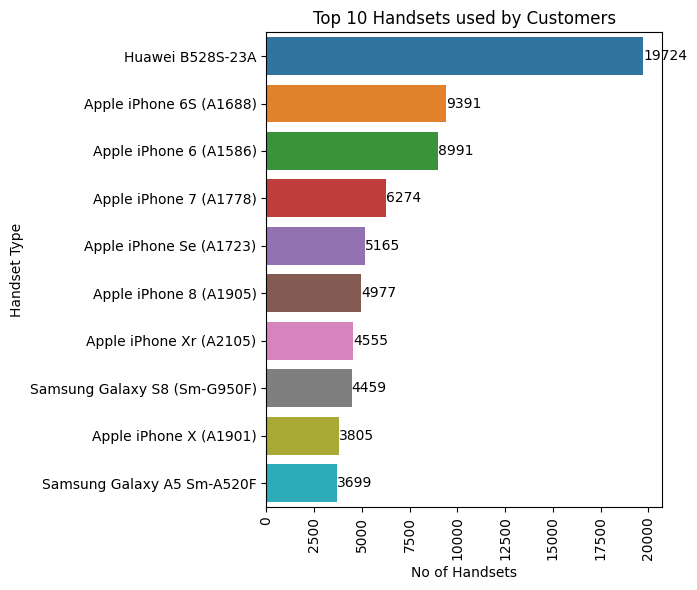

In [22]:
# Bar Plot of top 10 bandsets
plt.figure(figsize=(7, 6))
barplot = sn.barplot(x='count', y='Handset Type', data=top_10, hue='Handset Type')

# Add counts on the end of each bar
for index, value in enumerate(top_10['count']):
    barplot.text(value, index, f'{value}', va='center', ha='left', color='black')

# Rotate x-axis labels to 90 degrees
plt.xticks(rotation=90)

plt.title('Top 10 Handsets used by Customers')
plt.ylabel('Handset Type')
plt.xlabel('No of Handsets')
plt.tight_layout()
plt.show()

In [24]:
# Top 3 manufactures
print('Top 3 Manufacturers')
top_3_manufacturers = ha.top_manufacturers(top_n=3).reset_index(name='no_of_manufacturer')
top_3 = top_3_manufacturers.reset_index(drop=True)

Top 3 Manufacturers


In [25]:
top_3

,Handset Manufacturer,no_of_manufacturer
0,Apple,59304
1,Samsung,40393
2,Huawei,34269


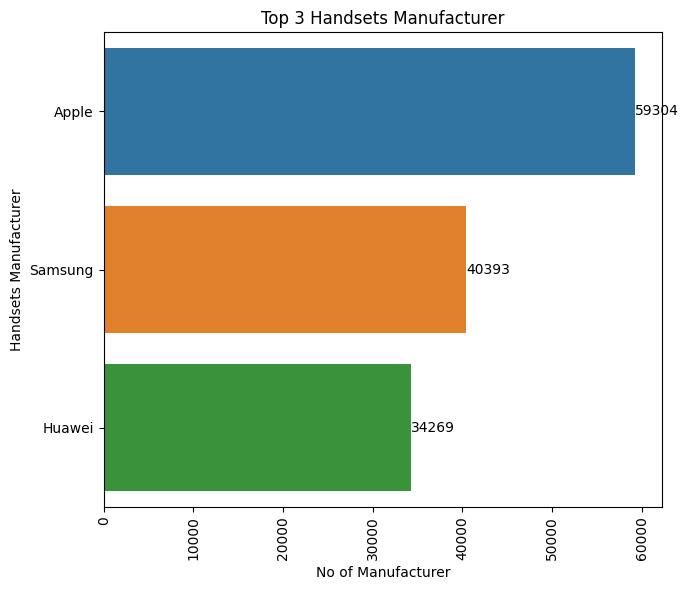

In [26]:
# Bar Plot of top 10 bandsets
plt.figure(figsize=(7, 6))
barplot = sn.barplot(x='no_of_manufacturer', y='Handset Manufacturer', data=top_3, hue='Handset Manufacturer')

# Add counts on the end of each bar
for index, value in enumerate(top_3['no_of_manufacturer']):
    barplot.text(value, index, f'{value}', va='center', ha='left', color='black')

# Rotate x-axis labels to 90 degrees
plt.xticks(rotation=90)

plt.title('Top 3 Handsets Manufacturer')
plt.ylabel('Handsets Manufacturer')
plt.xlabel('No of Manufacturer')
plt.tight_layout()
plt.show()

In [27]:
# Top 5 handest type per top 3 manufacturers
top_3_manufacturers = top_3_manufacturers['Handset Manufacturer'].tolist()
top_handsets_by_manufacturer = ha.top_handsets_per_manufacturer(
    top_3_manufacturers,
    top_n_handsets=5)

In [28]:
df_list = []

# Iterate through the dictionary
for manufacturer, series in top_handsets_by_manufacturer.items():
    # Convert each Series to a DataFrame
    df_temp = series.reset_index()
    df_temp.columns = ['Handset', 'Usage']
    df_temp['Manufacturer'] = manufacturer
    
    # Append to the list
    df_list.append(df_temp)
 # Concatenate all DataFrame parts into a single DataFrame
df = pd.concat(df_list, ignore_index=True)
df

,Handset,Usage,Manufacturer
0,Apple iPhone 6S (A1688),9391,Apple
1,Apple iPhone 6 (A1586),8991,Apple
2,Apple iPhone 7 (A1778),6274,Apple
3,Apple iPhone Se (A1723),5165,Apple
4,Apple iPhone 8 (A1905),4977,Apple
5,Samsung Galaxy S8 (Sm-G950F),4459,Samsung
6,Samsung Galaxy A5 Sm-A520F,3699,Samsung
7,Samsung Galaxy J5 (Sm-J530),3674,Samsung
8,Samsung Galaxy J3 (Sm-J330),3454,Samsung
9,Samsung Galaxy S7 (Sm-G930X),3169,Samsung


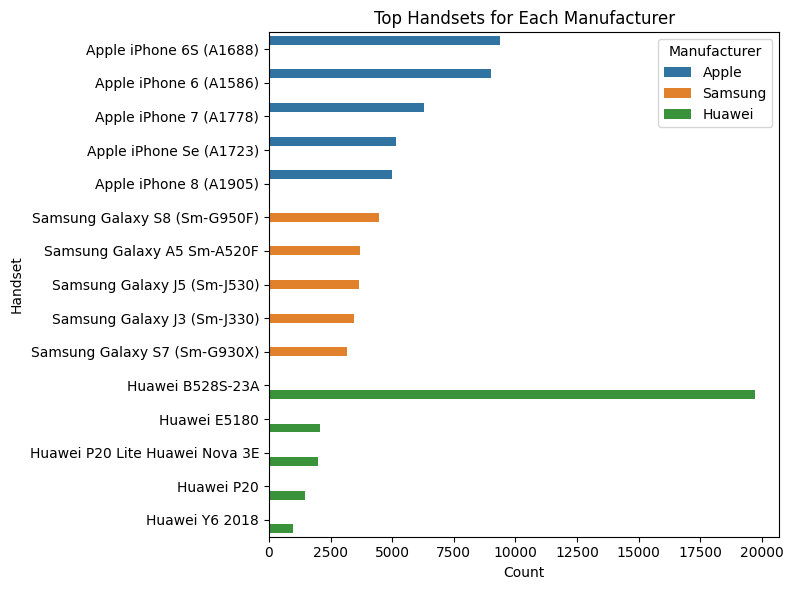

In [29]:
# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a nested bar chart using Seaborn
sn.barplot(
    x='Usage', 
    y='Handset', 
    hue='Manufacturer', 
    data=df,
    dodge=True,
    palette='tab10'  # Adjust color palette as needed
)

# Add titles and labels
plt.title('Top Handsets for Each Manufacturer')
plt.xlabel('Count')
plt.ylabel('Handset')

# Add legend
plt.legend(title='Manufacturer')

# Show the plot
plt.tight_layout()
plt.show()

Interpretation and Recommendations
Interpretation:

Apple: Popular older models like iPhone 6S and 6 indicate strong brand loyalty.
Samsung: Top handsets include both flagship and mid-range models, showing broad market appeal.
Huawei: High demand for the B528S-23A suggests strong interest in connectivity solutions.
Recommendations:

Apple: Promote older iPhones as cost-effective and introduce trade-in programs to drive upgrades.
Samsung: Emphasize the diverse product range and consider bundling offers for value.
Huawei: Focus on marketing connectivity devices and affordable smartphones to attract different customer segments.

#### Exploratory Analaysis



Task 1.1 - Your employer wants to have an overview of the users’ behavior on those applications.   
Aggregate per user the following information in the column  
number of xDR sessions
Session duration
the total download (DL) and upload (UL) data
the total data volume (in Bytes) during this session for each application


In [30]:
from user_analysis import UserBehavierAnalysis

ua = UserBehavierAnalysis(df_cleaned)
user_behavior = ua.aggregate_user_behavior()
user_behavior

,num_sessions,total_duration,total_dl,total_ul,total_data_volume,Social Media Total (Bytes),Google Total (Bytes),Email Total (Bytes),Youtube Total (Bytes),Netflix Total (Bytes),Gaming Total (Bytes),Other Total (Bytes)
Bearer Id,,,,,,,,,,,,
7.277826e+18,7187,5.107027e+08,3.256622e+12,2.964795e+11,3.553101e+12,1.314526e+10,5.651038e+10,1.618806e+10,1.623464e+11,1.628181e+11,3.081566e+12,3.085092e+12
7.277826e+18,1,6.887700e+04,4.817962e+08,5.707265e+07,5.388688e+08,2.297489e+06,7.089856e+06,4.179137e+06,3.212472e+07,2.271750e+07,4.591106e+08,4.352496e+08
7.277826e+18,1,7.602100e+04,2.250455e+08,3.305897e+07,2.581044e+08,4.584830e+05,7.656205e+06,3.129074e+06,2.527019e+07,2.406866e+07,1.914386e+08,7.095589e+08
7.277826e+18,1,8.014600e+04,7.624866e+08,2.244628e+07,7.849329e+08,3.264615e+06,3.362673e+06,3.373687e+06,1.545703e+07,3.385721e+06,7.454283e+08,4.705468e+08
7.277826e+18,1,7.278300e+04,5.204721e+08,5.906656e+07,5.795387e+08,7.463880e+05,1.298977e+07,2.734014e+06,2.283276e+07,3.299065e+07,4.944420e+08,7.980796e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
1.311448e+19,1,1.170370e+05,3.236875e+08,3.977921e+07,3.634667e+08,3.637302e+05,5.363772e+06,3.986673e+06,3.165615e+07,1.913481e+07,2.906660e+08,7.106527e+08
1.311448e+19,1,1.074450e+05,8.031791e+08,3.967894e+07,8.428581e+08,1.433616e+06,1.038942e+07,2.115685e+06,1.421548e+07,2.451068e+07,7.802021e+08,5.245547e+07
1.311448e+19,1,1.304440e+05,3.491442e+08,4.527086e+07,3.944150e+08,2.864135e+06,6.944059e+06,2.633008e+06,1.442936e+07,2.790569e+07,3.261298e+08,7.069328e+08




Task 1.2 - Conduct an exploratory data analysis on those data & communicate useful insights. Ensure that you identify and treat all missing values and outliers in the dataset by replacing them with the mean or any possible solution of the corresponding column.

You’re expected to report about the following using Python script and slide  :
- Describe all relevant variables and associated data types (slide). findings. 


In [31]:
# Descriptions of relevant columns
import pandas as pd
descriptions = {
    'Bearer Id': 'Session Id for each user',
    'Start': 'Session start time',
    'Dur. (ms)': 'Session duration (ms)',
    'Total UL (Bytes)': 'Total upload data (bytes)',
    'Total DL (Bytes)': 'Total download data (bytes)',
    'Social Media UL (Bytes)': 'Upload data for social media (bytes)',
    'Social Media DL (Bytes)': 'Download data for social media (bytes)',
    'Google UL (Bytes)': 'Upload data for Google apps (bytes)',
    'Google DL (Bytes)': 'Download data for Google apps (bytes)',
    'Email UL (Bytes)': 'Upload data for email (bytes)',
    'Email DL (Bytes)': 'Download data for email (bytes)',
    'Youtube UL (Bytes)': 'Upload data for YouTube (bytes)',
    'Youtube DL (Bytes)': 'Download data for YouTube (bytes)',
    'Netflix UL (Bytes)': 'Upload data for Netflix (bytes)',
    'Netflix DL (Bytes)': 'Download data for Netflix (bytes)',
    'Gaming UL (Bytes)': 'Upload data for gaming (bytes)',
    'Gaming DL (Bytes)': 'Download data for gaming (bytes)',
    'Other UL (Bytes)': 'Upload data for other apps (bytes)',
    'Other DL (Bytes)': 'Download data for other apps (bytes)'
}
# Convert the descriptions dictionary into a DataFrame
desc = pd.DataFrame(list(descriptions.items()), columns=['Variable', 'Description'])
dtypes = df_cleaned[desc['Variable']].dtypes.reset_index(name='data types')['data types']
desc['data type'] = dtypes
desc

,Variable,Description,data type
0,Bearer Id,Session Id for each user,float64
1,Start,Session start time,datetime64[ns]
2,Dur. (ms),Session duration (ms),float64
3,Total UL (Bytes),Total upload data (bytes),float64
4,Total DL (Bytes),Total download data (bytes),float64
5,Social Media UL (Bytes),Upload data for social media (bytes),float64
6,Social Media DL (Bytes),Download data for social media (bytes),float64
7,Google UL (Bytes),Upload data for Google apps (bytes),float64
8,Google DL (Bytes),Download data for Google apps (bytes),float64
9,Email UL (Bytes),Upload data for email (bytes),float64


**User Engagement Analysis**

In [32]:
decile_summary = ua.segment_users_by_decile()
print(decile_summary)

   Decile  total_data_volume  total_duration
0       5       4.843758e+12    9.016376e+08
1       6       5.777243e+12    1.370762e+09
2       7       6.046701e+12    1.725868e+09
3       8       7.540902e+12    2.044507e+09
4       9       1.487391e+13    4.297391e+09


User Engagement Analysis Based on Session Duration and Data Usage

Key Insights:

Increasing Trend: As we move from decile 5 to decile 9, both total data usage and session duration significantly increase.
Data usage ranges from 5.81 TB in decile 5 to 15.9 TB in decile 9.
Session duration grows from 1.09 billion ms to 4.61 billion ms.

Interpretation:

Heavy Users: Users in the higher deciles (8-9) are the primary contributors to high data consumption and longer session durations.
Strategic Focus: Targeting higher decile users with tailored plans or services could maximize engagement and revenue opportunities.



**Analysis of Statistical Metrics in the Dataset**

To analyze the basic metrics like mean, median, standard deviation, and percentiles, we calculate these for key columns such as session duration and total data usage (upload + download).


**Quantitative Variables:**

`Dur. (ms)` (Session Duration in milliseconds): Measures the length of user sessions. This is a continuous variable that represents how long a session lasts.

`Total UL (Bytes)` (Total Upload Data): Represents the total amount of data uploaded by users in bytes. This is a continuous variable showing the volume of data uploaded.

`Total DL (Bytes)` (Total Download Data): Represents the total amount of data downloaded by users in bytes. This is also a continuous variable indicating the volume of data downloaded.

In [33]:
# Import EDA module
from eda_pipeline import EDA
eda = EDA(df_cleaned)

In [34]:
# Basic Statistic and despersion metrics
quantitative_vars = ['Dur. (ms)', 'Total UL (Bytes)', 'Total DL (Bytes)']
eda.compute_basic_metrics(quantitative_vars)

,Dur. (ms),Total UL (Bytes),Total DL (Bytes)
Mean,9.906496e+04,4.111487e+07,4.544032e+08
Median,8.639900e+04,4.113592e+07,4.553048e+08
Mode,8.639900e+04,5.974506e+07,7.455622e+07
Standard Deviation,5.768286e+04,1.047880e+07,2.405902e+08
Variance,3.327312e+09,1.098052e+14,5.788363e+16
Range,2.217212e+05,3.729878e+07,7.597726e+08
IQR,7.268950e+04,1.581933e+07,4.228250e+08


**Basic Metrics Interpretation**

**Mean**:

Session Duration: 100,167 ms (100.2 seconds) indicates the average user session duration.
Total Upload (UL): 41 MB on average per session.
Total Download (DL): 454 MB on average per session.

Importance:

The mean provides insight into typical user behavior and data consumption, serving as a benchmark for assessing normal usage patterns.

**Median**:

Session Duration: 86,399 ms (86.4 seconds) shows the middle value of user session durations.
Total Upload (UL): 41 MB.
Total Download (DL): 456 MB.

Importance:

The median offers a robust measure of central tendency, less affected by outliers, representing the typical session duration and data usage.

**Mode:**

Session Duration: 86,399 ms (86.4 seconds) is the most frequently occurring session duration.
Total Upload (UL): 22 MB.
Total Download (DL): 75 MB.

Importance:

The mode highlights the most common session duration and data sizes, useful for identifying frequent patterns.


**Dispersion Metrics**

**Standard Deviation:**

Session Duration: 58,257 ms shows substantial variability in session lengths.
Total Upload (UL): 10.5 MB reflects moderate variability in upload sizes.
Total Download (DL): 240.6 MB indicates high variability in download sizes.

Importance:

Standard deviation measures the extent of dispersion around the mean, helping to understand the consistency or variability in session durations and data usage.

**Range:**

Session Duration: 221,721 ms indicates the spread between the shortest and longest sessions.
Total Upload (UL): 37.3 MB.
Total Download (DL): 759.8 MB.

Importance:

The range highlights the extent of variability within the data, pointing out the difference between minimum and maximum values.

**IQR (Interquartile Range):**

Session Duration: 74,591 ms represents the spread within the middle 50% of session durations.
Total Upload (UL): 15.8 MB.
Total Download (DL): 422.6 MB.

Importance:

IQR provides insight into the dispersion of the central portion of the data, useful for identifying and addressing outliers or significant spreads.

**Importance for the Global Objective:**

User Segmentation: These metrics allow us to classify users based on behavior, helping in targeting different segments for marketing or retention.

Service Optimization: By understanding the typical and extreme data usage, we can optimize services to cater to both average users and power users.

Product Strategy: Knowing the mean and variability in user engagement helps in designing personalized offerings that match user behavior.

---

**Graphical Univariate Analysis**
- it's essential to choose appropriate visualization methods for each quantitative variable to gain insights.

**Histogram for each  variables**

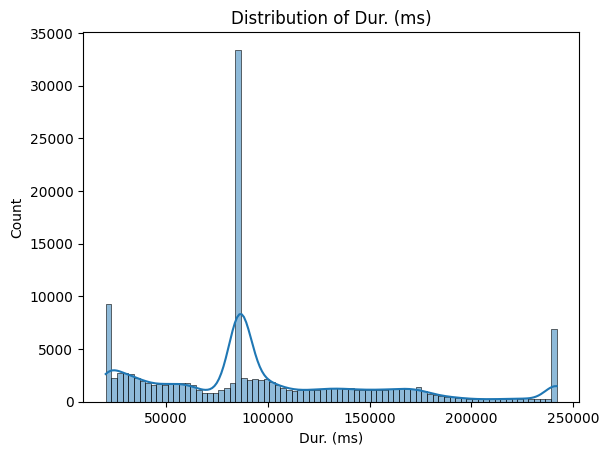

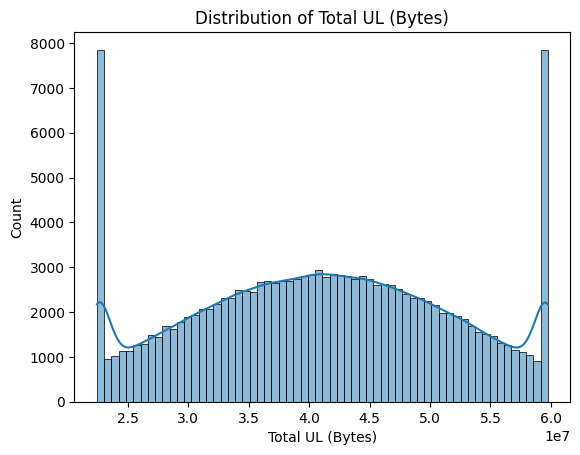

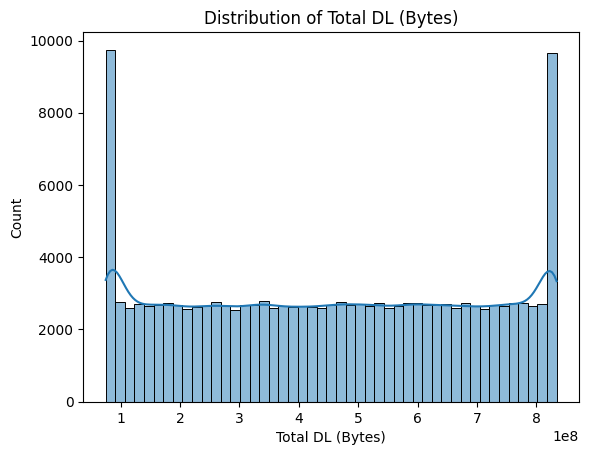

In [35]:
eda = EDA(df_cleaned)
# histogram for session duration
for col in quantitative_vars:
    eda.plot_distribution(col)

**Bivariate Analysis** – explore the relationship between each application & the total DL+UL data using appropriate methods and interpret your result


**Correlation Analysis of each applications**

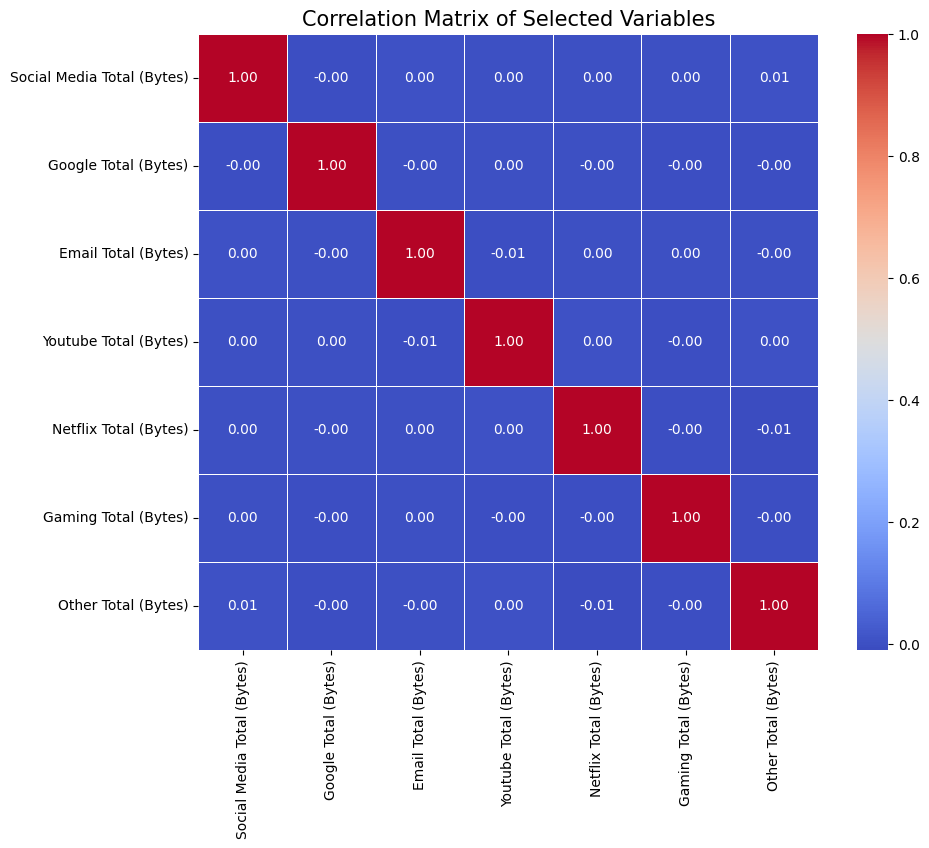

In [36]:
# Import necessary functions
# Define the variables of interest
variables = [
        'Social Media UL (Bytes)', 'Social Media DL (Bytes)',
        'Google UL (Bytes)', 'Google DL (Bytes)',
        'Email UL (Bytes)', 'Email DL (Bytes)',
        'Youtube UL (Bytes)', 'Youtube DL (Bytes)',
        'Netflix UL (Bytes)', 'Netflix DL (Bytes)',
        'Gaming UL (Bytes)', 'Gaming DL (Bytes)',
        'Other UL (Bytes)', 'Other DL (Bytes)'
    ]
correlation_matrix = eda.compute_correlation_matrix(variables)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the correlation matrix using seaborn's heatmap
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Title for the plot
plt.title('Correlation Matrix of Selected Variables', fontsize=15)

# Show the plot
plt.show()

**pca analysis**

In [37]:
# Define the variables of interest for PCA
variables = [
    'Social Media Total (Bytes)', 'Google Total (Bytes)',
    'Email Total (Bytes)', 'Youtube Total (Bytes)',
    'Netflix Total (Bytes)', 'Gaming Total (Bytes)',
    'Other Total (Bytes)'
]
pca_df, explained_var = eda.perform_pca(variables)

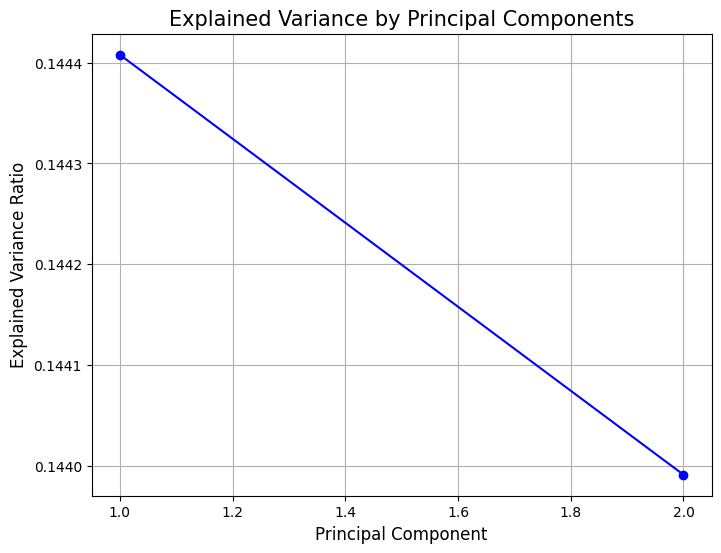

In [38]:
# Create an array of component numbers for the x-axis
components = np.arange(1, len(explained_var) + 1)

# Plot the explained variance
plt.figure(figsize=(8, 6))
plt.plot(components, explained_var, marker='o', linestyle='-', color='b')

# Add labels and title
plt.title('Explained Variance by Principal Components', fontsize=15)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)

# Show grid
plt.grid(True)

# Display the plot
plt.show()

In [39]:
# Save the cleaned data to csv
df_cleaned.to_csv('../Data/data/xdr_cleaned.csv')